# Sylhet Floods 2022
## run_inference.ipynb
This script runs inference of the NASA IMPACT machine learning algorithm, applied on the pre-processed and chipped Sentinel-1 data.

This code is adapated from the original code by Paul & Ganju (2021) at: https://github.com/sidgan/ETCI-2021-Competition-on-Flood-Detection

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import random
import rasterio as rio

In [27]:
# !pip3 install opencv-python

In [28]:
# !pip install torch

In [29]:
# !pip install torchvision

In [30]:
# !pip install ttach

In [31]:
# !pip install segmentation_models_pytorch

In [2]:
from tqdm.notebook import tqdm
from glob import glob

import cv2
import subprocess

from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import ttach as tta
import torch.nn as nn
import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Set the root path
rootPath = Path('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact')

## PART 0: Some helper functions

In [5]:
# Some helper functions from the original authors
# https://github.com/sidgan/ETCI-2021-Competition-on-Flood-Detection/blob/main/notebooks/Ensemble_Inference.ipynb

def get_test_id(path):
    return path.split("_")[0] + "_" + path.split("_")[1]

def make_im_name(id, suffix):
    return id.split(".")[0] + f"_{suffix}.png"

def s1_to_rgb(vv_image, vh_image):
    ratio_image = np.clip(np.nan_to_num(vh_image/vv_image, 0), 0, 1)
    rgb_image = np.stack((vv_image, vh_image, 1-ratio_image), axis=2)
    return rgb_image

## PART 1: Define locations of the VV and VH geotiffs

In [6]:
dataPath = rootPath/'4_Tiles'
dateFolders = list(dataPath.iterdir())
dates = [item.stem for item in dateFolders]

In [8]:
dates

['20220501',
 '20220511',
 '20220513',
 '20220523',
 '20220525',
 '20220604',
 '20220606',
 '20220616',
 '20220618',
 '20220628',
 '20220630',
 '20220712',
 '20220722',
 '20220724',
 '20220803',
 '20220805',
 '20220815',
 '20220827',
 '20220829']

In [9]:
dateFolders

[WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220501'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220511'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220513'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220523'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220525'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220604'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220606'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220616'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220618'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data/Raster/SylhetNASAImpact/4_Tiles/20220628'),
 WindowsPath('Z:/media/mule/Projects/NASA/NIP/Data

24 more VV than VH files: ['1_23', '1_17', '1_14', '1_11', '1_18', '1_5', '1_10', '1_16', '1_21', '1_20', '1_24', '1_22', '1_19', '1_12', '1_7', '1_2', '1_1', '1_9', '1_4', '1_13', '1_6', '1_3', '1_8', '1_15']
# chips: 876
(876, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220501\v2\20220501_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220511\v2\20220511_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220513\v2\20220513_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220523\v2\20220523_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220525\v2\20220525_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

21 more VH than VV files: ['32_20', '32_24', '32_12', '32_6', '32_18', '32_7', '32_19', '32_13', '32_22', '32_23', '32_5', '32_14', '32_16', '32_11', '32_4', '32_10', '32_15', '32_17', '32_9', '32_21', '32_8']
# chips: 879
(879, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220606\v2\20220606_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220616\v2\20220616_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220618\v2\20220618_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220628\v2\20220628_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220630\v2\20220630_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220712\v2\20220712_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220722\v2\20220722_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220724\v2\20220724_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220803\v2\20220803_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220805\v2\20220805_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

16 more VV than VH files: ['32_20', '32_24', '32_12', '32_18', '32_19', '32_13', '32_22', '32_23', '32_14', '32_16', '32_11', '32_10', '32_15', '32_17', '32_9', '32_21']
# chips: 884
(884, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

OKeating file Z:\media\mule\Projects\NASA\NIP\Data\Raster\SylhetNASAImpact\5_Preds\20220827\v2\20220827_9_9.tifff
# chips: 900
(900, 2)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

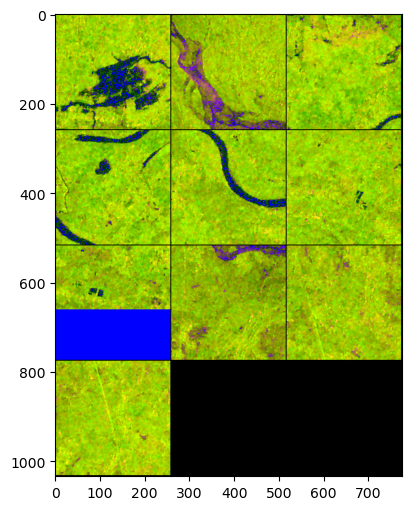

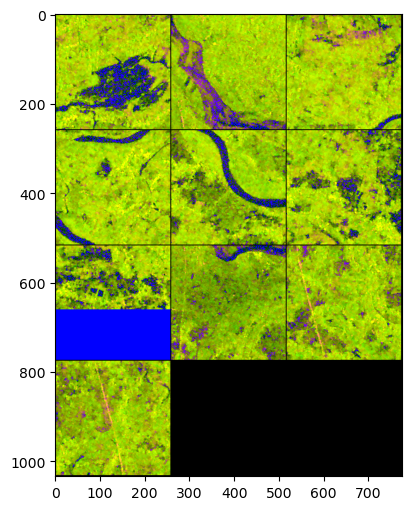

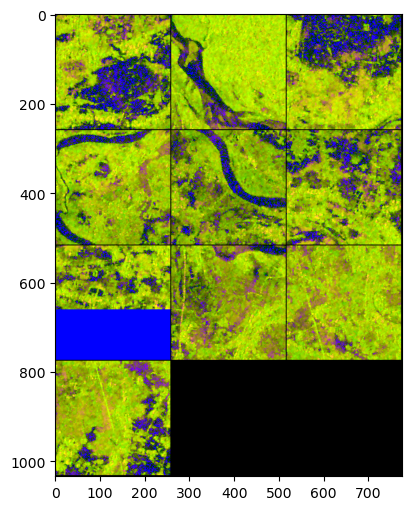

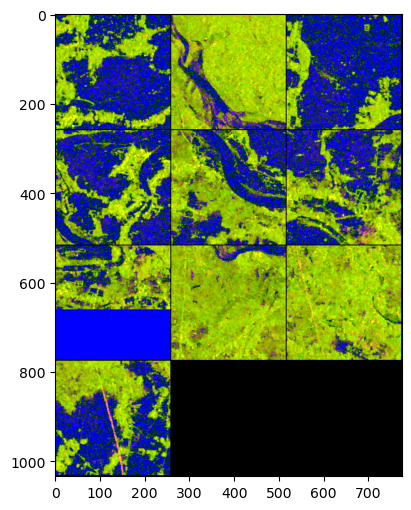

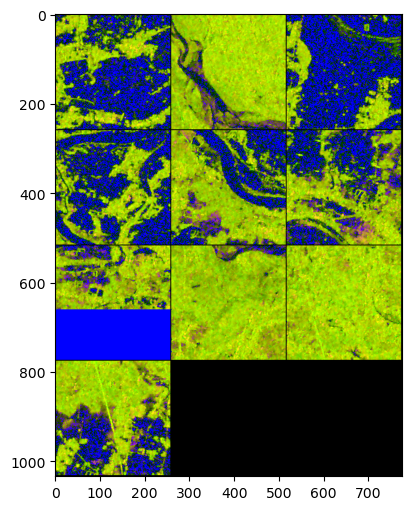

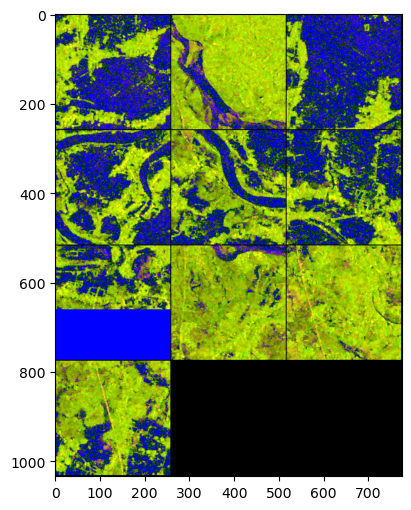

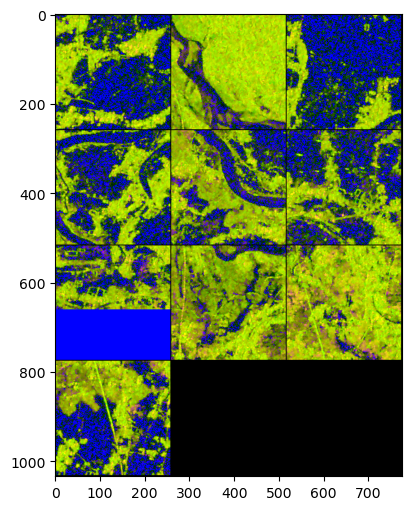

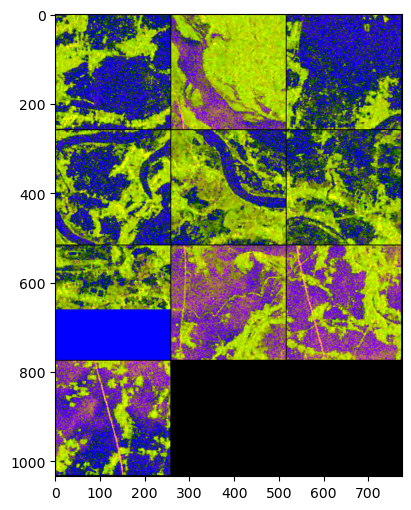

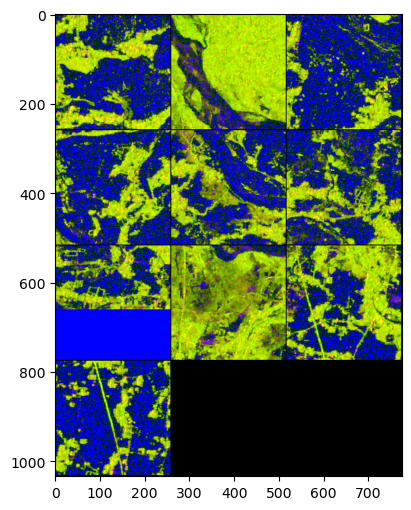

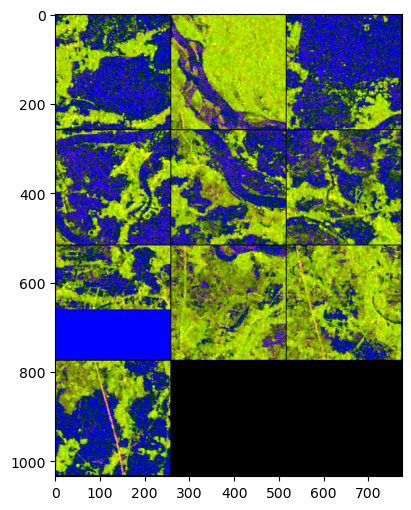

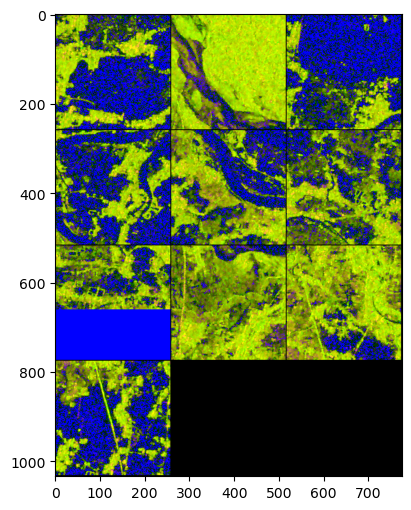

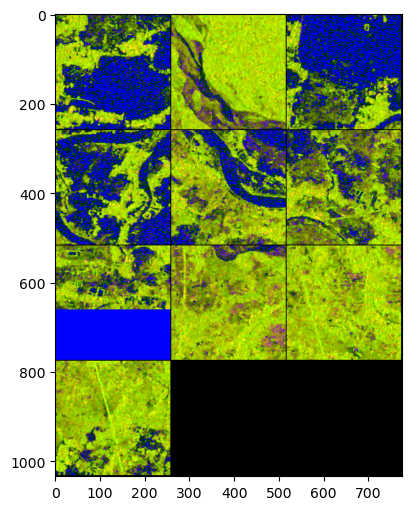

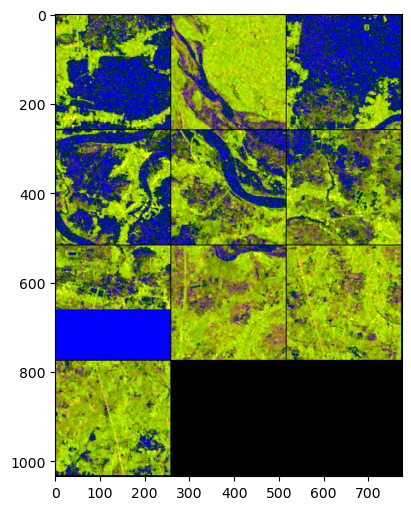

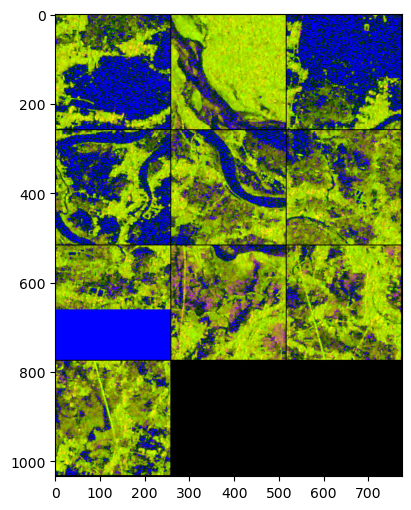

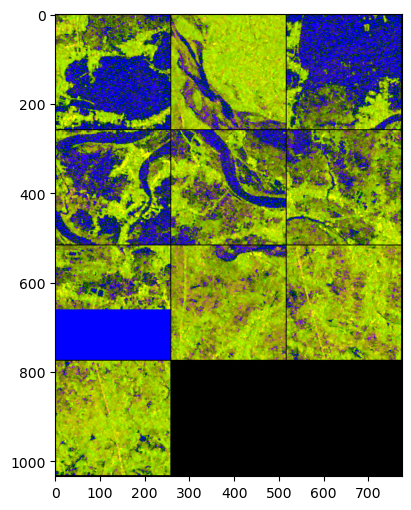

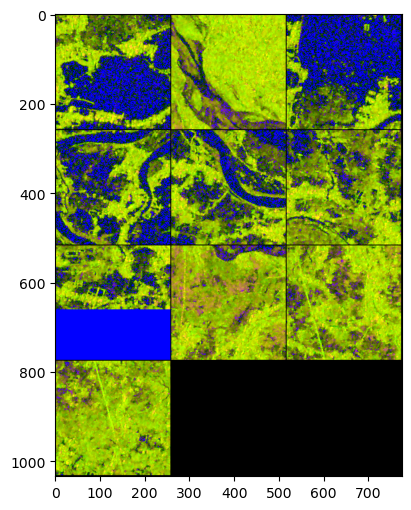

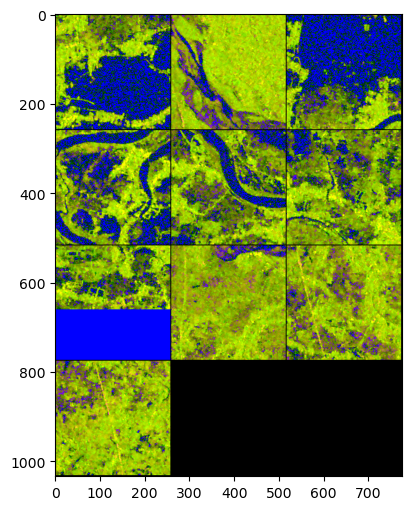

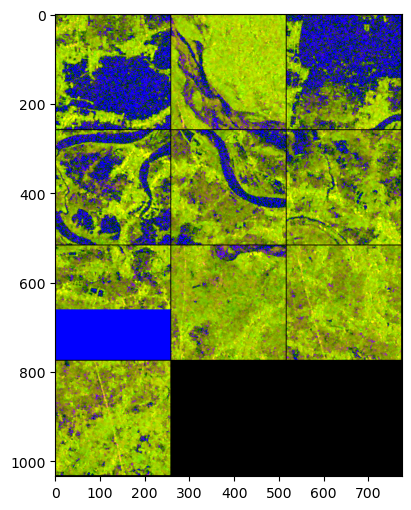

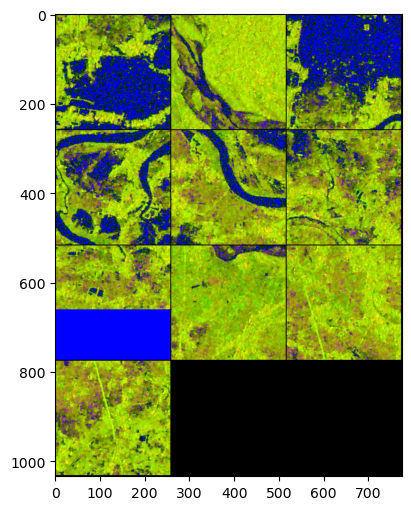

In [13]:
# Loop through dates
for i, date in enumerate(dates):
    
    dateFolder=dateFolders[i]

    # Get the VV and VH files
    vv_files = [file for file in list(dateFolder.iterdir()) if 'VV.tif' in str(file)]
    vh_files = [file for file in list(dateFolder.iterdir()) if 'VH.tif' in str(file)]

    # Get the tileIDs
    vv_IDs = ['_'.join(str(item.stem).split('_')[1:3]) for item in vv_files]
    vh_IDs = ['_'.join(str(item.stem).split('_')[1:3]) for item in vh_files]

    # Check same no files
    if len(list(set(vh_IDs).difference(vv_IDs)))>0:
        print(len(list(set(vh_IDs).difference(vv_IDs))), 'more VH than VV files:', list(set(vh_IDs).difference(vv_IDs)))
    elif len(list(set(vv_IDs).difference(vh_IDs)))>0:
        print(len(list(set(vv_IDs).difference(vh_IDs))), 'more VV than VH files:', list(set(vv_IDs).difference(vh_IDs)))
    else:
        print('OK')

    # Get the unique tileIDs, check for duplicates and keep only IDs included in both
    IDs = [value for value in vv_IDs if value in vh_IDs]
    IDs_uniq = np.unique(IDs)

    # Check for duplicates chips
    if len(IDs_uniq)!=len(IDs):
        print('Warning: Duplicate chip IDs')
    else:
        print('# chips:', len(IDs_uniq))

    # For now, just take the files where both VV and VH exists
    VV_files = [item for item in vv_files if '_'.join(str(item.stem).split('_')[1:3]) in IDs_uniq]
    VH_files = [item for item in vh_files if '_'.join(str(item.stem).split('_')[1:3]) in IDs_uniq]

    # Create df of image paths
    paths = {'vv_image_path': VV_files,
             'vh_image_path': VH_files,
    }

    test_df = pd.DataFrame(paths)
    print(test_df.shape)


    # ETCI dataset class, from the original NASA IMPACT competition
    class ETCIDataset(Dataset):
        def __init__(self, dataframe, split, transform=None):
            self.split = split
            self.dataset = dataframe
            self.transform = transform

        def __len__(self):
            return self.dataset.shape[0]


        def __getitem__(self, index):
            example = {}

            df_row = self.dataset.iloc[index]

            # load vv and vh images
            vv_image = cv2.imread(str(df_row['vv_image_path']), 0) / 255.0
            vh_image = cv2.imread(str(df_row['vh_image_path']), 0) / 255.0

            # convert vv and ch images to rgb
            rgb_image = s1_to_rgb(vv_image, vh_image)

            if self.split == 'test':
                # no flood mask should be available
                example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
            else:
                # load ground truth flood mask - *** this doesn't apply here as we are only running inference
                flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

                # compute transformations
                if self.transform:
                    augmented = self.transform(image=rgb_image, mask=flood_mask)
                    rgb_image = augmented['image']
                    flood_mask = augmented['mask']

                example['image'] = rgb_image.transpose((2,0,1)).astype('float32')
                example['mask'] = flood_mask.astype('int64')

            return example


    # Create the test ETCI dataset from the dataframe of paths to VV and VH files
    test_dataset = ETCIDataset(test_df, split='test', transform=None)

    # # Create a smaller subset for testing
    # test_dataset = ETCIDataset(test_df[0:10], split='test', transform=None)

    # Create the DataLoader
    # batch_size = 96 * torch.cuda.device_count()
    batch_size = 96
    # nworkers = os.cpu_count()
    nworkers = 0
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                             num_workers=nworkers, pin_memory=True)


    # Create function to show images
    def matplotlib_imshow(img, one_channel=False):
        fig,ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img.permute(1,2,0).numpy())


    # Read the images from the loader
    images = next(iter(test_loader))['image']

    # Plot the images
    import os    
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    img_grid = torchvision.utils.make_grid(images[10:20], nrow=3, normalize=False) #images[50:59]
    matplotlib_imshow(img_grid)


    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


    # Create function to get the predictions
    def get_predictions_single(model_def, weights):

        if torch.cuda.is_available():
            model_def.load_state_dict(torch.load(weights))
        else:
            model_def.load_state_dict(torch.load(weights, map_location=torch.device('cpu')))       

        model = tta.SegmentationTTAWrapper(model_def, tta.aliases.d4_transform(), merge_mode='mean') # mean yields the best results
        model.to(device)

        #torch.load with map_location=torch.device('cpu')

        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        final_predictions = []

        model.eval()
        with torch.no_grad():
            for batch in tqdm(test_loader):
                # load image and mask into device memory
                image = batch['image'].to(device)

                # pass images into model
                pred = model(image)

                # add to final predictions
                final_predictions.append(pred.detach().cpu().numpy())

        final_predictions = np.concatenate(final_predictions, axis=0)

        return final_predictions


    # Unet and U++ models

    unet_mobilenet = smp.Unet(
        encoder_name="mobilenet_v2", 
        encoder_weights=None, 
        in_channels=3,    # change to 1?               
        classes=2                      
    )

    upp_mobilenet = smp.UnetPlusPlus(
        encoder_name="mobilenet_v2", 
        encoder_weights=None, 
        in_channels=3,                  
        classes=2                      
    )

    model_defs = [unet_mobilenet, upp_mobilenet]

    # Read the pre-trained weights
    modelPath = 'C:/Users/alexsaunders/Documents/01_uoa/04_git/NIP/SylhetNASAImpact/Modeling/pretrained_weights/'

    model_paths = [modelPath+'unet_mobilenet_v2_0.pth',
                  modelPath+'upp_mobilenetv2_0.pth']


    # Predictions
    all_preds = []

    for defi, path in zip(model_defs, model_paths):
        all_preds.append(get_predictions_single(defi, path))


    all_preds = np.array(all_preds)
    all_preds = np.mean(all_preds, axis=0)
    class_preds = all_preds.argmax(axis=1).astype('uint8')


    # Create the output folder for saving the predicted chips
    PredsPath = rootPath/'5_Preds'
    PredsPath.mkdir(exist_ok=True)


    # Loop through the dates - for now, running one at a time
    PredsDatePath = PredsPath/date/'v2'
    PredsDatePath.mkdir(exist_ok=True)

    # Loop through predictions, get the new file name and export as tif
    for i, pred in enumerate(class_preds):

        origFile = test_df.iloc[i]['vv_image_path']
        PredsFile = PredsDatePath/(origFile.stem[:-3]+origFile.suffix)

        # Check if already exists in which case skip to the next 
        if os.path.exists(PredsFile):
            continue
        print(f"Creating file {PredsFile}", end='\r')

        # Open the original file to get the necessary raster metadata
        raster=rio.open(origFile)
        # array=raster.read(1)
        profile = raster.profile
        profile.update(nodata=255)
        raster=None

        # Write out as tiff
        with rio.open(PredsFile, 'w', **profile) as raster_out:
            raster_out.write(pred, 1)